In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils
from torchvision import models
from torchvision.models import ResNet18_Weights
from PIL import Image

import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data Loaders

### Dataset for Returning Image and Class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, binary=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.binary = binary

       # Add a 'label' column to the DataFrame
        if self.binary:
            self.data['label'] = self.data['real_age'].apply(lambda age: 0 if age < 25 else 1)
            self.classes = self.data['label'].unique().tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg'
        label = row['label']

        # Load image
        image = Image.open(img_path).convert('RGB')  # Load RGB
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

### Transformations for Data Augmentation and Normalisation

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8,1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Create Dataset from CSV

In [5]:
train_csv = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_train.csv'
val_csv = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_valid.csv'
test_csv = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_test.csv'

train_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_train'
val_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_valid'
test_dir = '/Users/sambeattie/Documents/Level4Project/appa-real-release/cropped_test'


# Create datasets
train_dataset = CustomDataset(csv_file=train_csv, image_dir=train_dir, transform=train_transforms, binary=True)
val_dataset = CustomDataset(csv_file=val_csv, image_dir=val_dir, transform=val_transforms, binary=True)
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms, binary=True)

In [6]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

print(f"Classes: {train_dataset.classes}. 0<25yo | 1>=25yo")


Train Dataset Size: 3920
Val Dataset Size: 1438
Test Dataset Size: 1828
Classes: [0, 1]. 0<25yo | 1>=25yo


### Stratification

In [7]:
# Compute class weights
class_counts = train_dataset.data['label'].value_counts()
class_weights = 1.0 / class_counts
sample_weights = train_dataset.data['label'].map(class_weights)

# Create sampler
sampler = sampler.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

### Creating Loaders

In [8]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

### Display Batches

Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Image Classes: tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1])
Class 1 Images: 15
Class 0 Images: 17


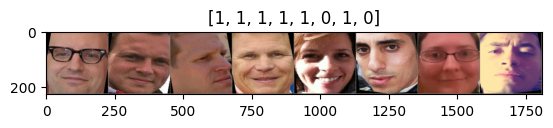

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        pass
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get one batch of data
data_iter = iter(train_loader)  # Create an iterator from the DataLoader
images, labels = next(data_iter)  # Get the first batch

# Print out the shapes of images and labels
print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Image Classes: {labels}")

print(f"Class 1 Images: {torch.sum(labels)}")
print(f"Class 0 Images: {len(labels) - torch.sum(labels)}")

n = 8

# Make a grid from batch
out = utils.make_grid(images[:n])

imshow(out, title=[x.item() for x in labels[:n]])

# Model Training

## Using Pytorch pretrained ResNet model - trained on ImageNet

In [10]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

In [11]:
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

Number of features from pre-trained model 512


### Add a fully connected layer which maps from 512 -> 1
- Freeze weights for existing parameters of pretrained model
    - These dont need retrained since we are doing transfer learning
- Add a fully connected linear layer
    - This maps from the output of the pretrained model (512)
    - To the output we want for our classifier (1 - the probability of being a certain class)
- The weights in this layer will be trained to fit our data

In [12]:
# Freeze the layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(num_features, 1)

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

### Train and Test functions

In [13]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Forward Pass
        output = model(data)

        # Compute Loss
        # Squeeze output: (32, 1) -> (32,) to match target shape (32,)
        # Convert target to float: Targets are integers 0,1. Loss function expects float
        loss = criterion(output.squeeze(), target.float()) 

        # Backwards pass and optimisation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [14]:
def val(model, device, val_loader, criterion, epoch):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Compute loss
            val_loss += criterion(output.squeeze(), target.float()).item()  # Sum up batch loss
            
            # # Apply sigmoid to logits to get probabilities
            # output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average the val loss over the entire dataset
    val_loss /= len(val_loader)
    
    # Print results
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, 10 + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    val(model, device, val_loader, criterion, epoch)

Train Epoch: 1 [0/3920 (0%)]	Loss: 0.749050
Train Epoch: 1 [320/3920 (8%)]	Loss: 0.841448
Train Epoch: 1 [640/3920 (16%)]	Loss: 0.722137
Train Epoch: 1 [960/3920 (24%)]	Loss: 0.677686
Train Epoch: 1 [1280/3920 (33%)]	Loss: 0.639313
Train Epoch: 1 [1600/3920 (41%)]	Loss: 0.648840
Train Epoch: 1 [1920/3920 (49%)]	Loss: 0.568638
Train Epoch: 1 [2240/3920 (57%)]	Loss: 0.607024
Train Epoch: 1 [2560/3920 (65%)]	Loss: 0.623001
Train Epoch: 1 [2880/3920 (73%)]	Loss: 0.696900
Train Epoch: 1 [3200/3920 (81%)]	Loss: 0.688790
Train Epoch: 1 [3520/3920 (89%)]	Loss: 0.671876
Train Epoch: 1 [3840/3920 (98%)]	Loss: 0.668953

Validation set: Average loss: 0.6557, Accuracy: 798/1438 (55%)

Train Epoch: 2 [0/3920 (0%)]	Loss: 0.729767
Train Epoch: 2 [320/3920 (8%)]	Loss: 0.581967
Train Epoch: 2 [640/3920 (16%)]	Loss: 0.528409
Train Epoch: 2 [960/3920 (24%)]	Loss: 0.506342
Train Epoch: 2 [1280/3920 (33%)]	Loss: 0.538080
Train Epoch: 2 [1600/3920 (41%)]	Loss: 0.660840
Train Epoch: 2 [1920/3920 (49%)]	Loss: 